---
---
# <div style="display: flex; justify-content: center">**Trustworty AI Homework**</div>
<div style="display: flex; justify-content: center">
    <span style="font-weight: bold; margin-right: 10px;">Topic:</span>
    <span>Esports analysis - Predicting round winning team in professional Counter Strike (thesis topic)</span>
</div>
<div style="display: flex; justify-content: center">
    <span style="font-weight: bold; margin-right: 10px;">Name:</span>
    <span>Patrik Peter Szmida</span>
</div>
<div style="display: flex; justify-content: center">
    <span style="font-weight: bold; margin-right: 10px;">Neptun:</span>
    <span style="margin-bottom: 15px;">G0HPLP</span>
</div>

---
---


# **I. Milestone: Exploratory data analysis and visualization**

## I. I. Topic and aim of project

The topic I chose is the one on which I'm working in my thesis, which deals with professional Counter Strike esports analytics. Similar to traditional sports, in esports, individuals or teams compete in a regulated environment defined by the rules of the game. One of the most globally recognized esports is Counter Strike, a first-person shooter game in which two teams of five compete for victory in a match through intense rounds. The replays of the professional matches in the highest-tier leagues serve as the dataset for this project. In my thesis, my aim is to create models that are able to predict the round-winning team (based on the actual game state) for every second of the examined round as accurately as possible using graph neural networks. In this subject's homework, my aim is to do a detailed data exploratory analysis with visualizations in the first milestone and to create both whitebox and blackbox (graph neural network) models in the second in order to predict the winning team of the round and do a detailed comparison.


## I. II. About Counter Strike

Counter Strike (CS) is one of the most well-known esports worldwide. In this esport, two opposing teams go up against one another. The players of the teams first chose their role by choosing sides: attackers, known as Terrorists, and defenders, known as Counter-Terrorists. The game has seven unique maps, each creating a different environment for the players. A match takes place on one of these maps and is made out of rounds lasting two minutes. The Terrorists (T) aim to plant the bomb and detonate it at the areas on the maps called “bomb sites”, while the Counter-Terrorists’ (CT) objective is to prevent this from happening or defuse the bomb if it was planted. The ultimate objective for each team is to either eliminate the opposing team or complete their role objectives within each round before the timer reaches zero. The game is split up into two halves, each with a maximum span of 15 rounds. The two teams switch roles after the first half (CTs become Ts and vice versa), and the match continues. The first team to reach 16 rounds wins.

(I focused my analysis on matches played on one of the most popular maps called *Inferno* in both in my thesis and in this homework.)


## I. III. The dataset

One of the main advantages of esports over traditional sports is that it is played in a virtual enviroment, thus, the matches can be replayed in exactly the way they happened. In the case of Counter Strike, there is an organization called <a href="https://www.hltv.org/">HLTV</a> which specializes in collecting the replays and in-game statistics of the professional leagues and events and sharing them publicly on their website. The replays of these matches can be used not only to review the whole matches while being in game, but also to collect data from them. One significant advantage of esports from a data analyst's perspective is that since these are highly popular competitive games with numerous players, professionals, and large prize pools in professional leagues, errors cannot occur during gameplay. The companies behind these games ensure this, making the occurrence of missing or corrupted data in the replays nearly impossible (since these are exact copies of the matches that were played, thus an error would have to occur in the actual match for the demo file to be corrupted).

In the previous semester I downloaded the matches of the highest-tier tournaments played between 2022-2023/Q2 and used the <a style="font-style: italic;" href="https://awpy.readthedocs.io/en/latest/">awpy</a> python package created by Peter Xenopoulos to parse these match replays called demo files. As a result, I have received all the information regarding the matches played on the map *Inferno*, including player positions, speeds, weapons used, where they are looking, remaining utilities (grenades), etc., at a rate of 64 game snapshots per second (for the final project, however, I used data with a granularity of 1 game state representation per second).

In order to leverage graph neural networks, I had to transform the game-states into graphs. The first step towards this was to create a graph that represents the map *Inferno*.  This was created by examining player movements, contact areas, parts, elements and the layout of the map. The result can be seen on **Image 1**.

<div style="display: flex; flex-direction: column; align-items: center; ">
    <img src="src/graph_dataset_image.png" style="height: 600px;">
    <div style="margin-top: 10px; display: flex; justify-content: center;">Image 1: Layout and graph of the Inferno map.</div>
</div>

With this graph, I was able to create game state representations for every second by adding the players as a new type of node (making these graphs heterogeneous), connecting them to the nearest map node, and also adding some graph-level features like remaining time, round number, etc. After doing this for the matches collected, I had a graph dataset with ~65 000 heterogeneous graphs.

A single graph had the following properties:
- **node types**:
  - ***map*** type nodes with features:
    - x, y coordinates
    - whether the node is a common contact spot or not
  - ***player*** type nodes with features:
    - x, y, z coordinates
    - the velocities in all directions at the actual second (x, y, z)
    - the direction in which he looks at the actual second (x, y, z)
    - information about the actual equipment (weapons, active weapon, grenades, etc.)
    - statistics from the current game (number of kills, deaths, assists, etc.)
    - overall performance describing metrics (data from <a href="https://www.hltv.org/stats/players?startDate=all&rankingFilter=Top20">HLTV player statistics</a>) **\***
- **edge types**:
  - ***map connected_to map***: edge type that connects two *map* type nodes
  - ***player closest_to map***: edge type that connects a *player* type node with a *map* type node
- **graph level features**:
  - round number
  - time
  - number of players alive on each team
  - whether the defenders win the round (this is the output)

An example graph from the dataset can be seen on **Image 2**.

<div style="display: flex; flex-direction: column; align-items: center; ">
    <img src="src/example_graph.png" style="height: 600px;">
    <div style="margin-top: 10px; display: flex; justify-content: center;">Image 2: Example graph visualized from the dataset.</div>
</div>

**\***: While creating the graph dataset last semester, a merging error occured while adding the overall player statistics to the player nodes' feature set. As a result, some player nodes doesn't have these features (they are all NaN-s). For this reason, the visualization of this data is done separately during this milestone. 

## I. IV. Visualization

Data exploratory analysis and visualization of the chosen topic. The visualization is devided into two parts: in the first I examine the graph dataset, in the second I do an analysis of the player overall statistical dataset (these are separated for the reasons mentioned before). First steps are the preparations. 

Datatsets are available on drive (due to it's size):
 - Graph dataset
 - Player overall statistics dataset

In [238]:
from torch_geometric.data import HeteroData, DataLoader, Dataset
import matplotlib.patches as patches
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from math import ceil, floor
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import os

# ---------------------------------------------

class InfernoDataset(Dataset):
    def __init__(self, data_list):
        super(InfernoDataset, self).__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

In [2]:
dataset = torch.load('../model/graph-dataset/semester-1/inferno_graph_dataset.pt')

In [223]:
df_created = False
match_id = np.random.randint(10000000,99999999)
roundNum = 0

for graph in dataset:
    if graph['y']['roundNum'] < roundNum:
        match_id = np.random.randint(10000000,99999999)
    roundNum = graph['y']['roundNum']
    temp = pd.DataFrame(data=graph['player']['x'][:,0:3].numpy(), columns=['x', 'y', 'z'])
    temp['roundNum'] = roundNum
    temp['sec'] = graph['y']['sec']
    temp['team1AliveNum'] = graph['y']['team1AliveNum'].numpy()
    temp['team2AliveNum'] = graph['y']['team2AliveNum'].numpy()
    temp['CTwinsRound'] = graph['y']['CTwinsRound'].numpy()
    temp['match_id'] = match_id
    if not df_created:
        df = temp
        df_created = True
    else:
        df = pd.concat([df, temp])

---

### I. IV. - 0. Images used in the description part

In this section I created the plots I used in the description part of the document.

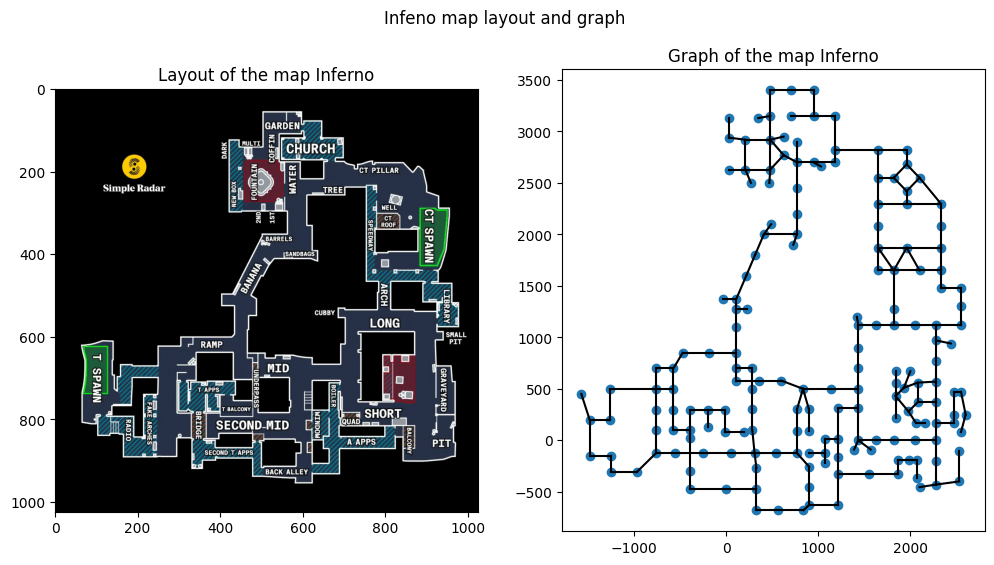

In [4]:
fig, axs = plt.subplots(1,2,figsize=(12,6))

img = mpimg.imread('src/inferno_layout.png')
imgplot = axs[0].imshow(img)
axs[0].set_title("Layout of the map Inferno")

graphnodes = pd.DataFrame(data=dataset[0]['map']['x'].numpy(), columns=['x','y','path'])
graphedges = pd.DataFrame(data=dataset[0]['map','connected_to','map']['edge_index'].numpy().T, columns=['startIdx', 'endIdx'])

axs[1].scatter(graphnodes['x'], graphnodes['y'])
for idx, edge in graphedges.iterrows():
    axs[1].plot([graphnodes.iloc[edge['startIdx']]['x'], graphnodes.iloc[edge['endIdx']]['x']], [graphnodes.iloc[edge['startIdx']]['y'], graphnodes.iloc[edge['endIdx']]['y']], c='black',zorder=1)
axs[1].set_title("Graph of the map Inferno")
plt.suptitle('Image 1\nInfeno map layout and graph')
plt.show()

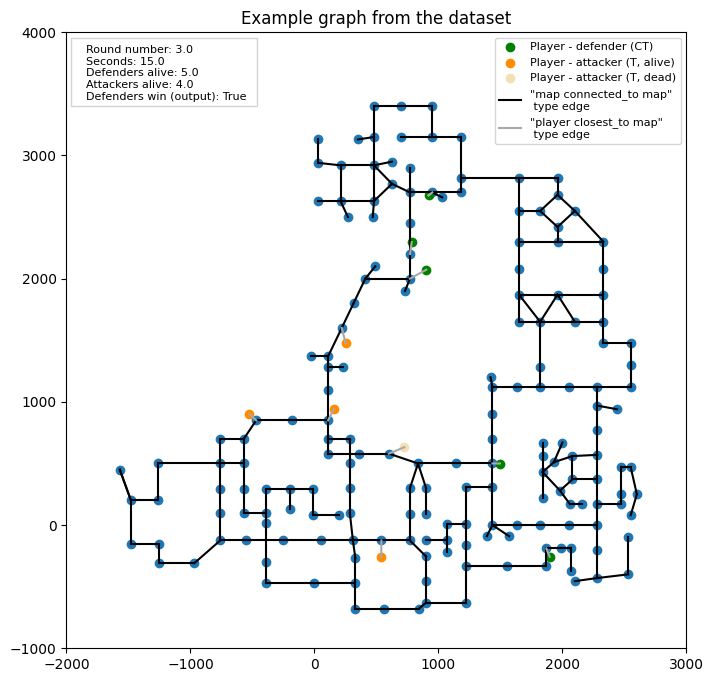

In [69]:
# Text changer function
def defendersWinText(data):
    if data == 1:
        return True
    else:
        return False

# Bases
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.set_title("Example graph from the dataset")
plotted_graph = dataset[175]

# Collected data
graphnodes = pd.DataFrame(data=plotted_graph['map']['x'].numpy(), columns=['x','y','path'])
graphedges = pd.DataFrame(data=plotted_graph['map','connected_to','map']['edge_index'].numpy().T, columns=['startIdx', 'endIdx'])
playernodes = pd.DataFrame(data=plotted_graph['player']['x'][:,0:2].numpy(), columns=['x','y'])
playernodes['isAlive'] = plotted_graph['player']['x'][:,15].numpy()
playeredges = pd.DataFrame(data=plotted_graph['player','closest_to','map']['edge_index'].numpy().T, columns=['startIdx', 'endIdx'])

# Scatter dots, add the first edges manually (labeling purposes)
ax.scatter(graphnodes['x'], graphnodes['y'])
ax.scatter(playernodes[0:5]['x'], playernodes[0:5]['y'], c='green', label="Player - defender (CT)")
ax.scatter(playernodes[5:].loc[playernodes['isAlive'] == 1]['x'], playernodes[5:].loc[playernodes['isAlive'] == 1]['y'], c='darkorange', label="Player - attacker (T, alive)")
ax.scatter(playernodes[5:].loc[playernodes['isAlive'] == 0]['x'], playernodes[5:].loc[playernodes['isAlive'] == 0]['y'], c='wheat', label="Player - attacker (T, dead)")
ax.plot([graphnodes.iloc[graphedges.iloc[0]['startIdx']]['x'], graphnodes.iloc[graphedges.iloc[0]['endIdx']]['x']],\
        [graphnodes.iloc[graphedges.iloc[0]['startIdx']]['y'], graphnodes.iloc[graphedges.iloc[0]['endIdx']]['y']],\
         c='black',zorder=1, label="\"map connected_to map\"\n type edge")
ax.plot([playernodes.iloc[playeredges.iloc[0]['startIdx']]['x'], graphnodes.iloc[playeredges.iloc[0]['endIdx']]['x']],\
        [playernodes.iloc[playeredges.iloc[0]['startIdx']]['y'], graphnodes.iloc[playeredges.iloc[0]['endIdx']]['y']],\
         c='darkgray',zorder=1, label="\"player closest_to map\"\n type edge")

# Draw map-tp-map edges
for idx, edge in graphedges.iterrows():
    ax.plot([graphnodes.iloc[edge['startIdx']]['x'], graphnodes.iloc[edge['endIdx']]['x']], [graphnodes.iloc[edge['startIdx']]['y'], graphnodes.iloc[edge['endIdx']]['y']], c='black',zorder=1)
# Draw player-to-map edges
for idx, edge in playeredges.iterrows():
    ax.plot([playernodes.iloc[edge['startIdx']]['x'], graphnodes.iloc[edge['endIdx']]['x']], [playernodes.iloc[edge['startIdx']]['y'], graphnodes.iloc[edge['endIdx']]['y']], c='darkgray',zorder=1)

# Draw graph level features into a square
plt.figtext(0.15,0.796,"Round number: {}\nSeconds: {}\nDefenders alive: {}\nAttackers alive: {}\nDefenders win (output): {}"\
            .format(plotted_graph['y']['roundNum'], plotted_graph['y']['sec'], plotted_graph['y']['team1AliveNum'],\
                    plotted_graph['y']['team2AliveNum'], defendersWinText(plotted_graph['y']['CTwinsRound'])), fontsize=8)
square_info = patches.Rectangle((-1960, 3400), 1500, 550, edgecolor='lightgray', facecolor='none', linewidth=1,)
ax.add_patch(square_info)

ax.set_xlim(-2000,3000)
ax.set_ylim(-1000,4000)
ax.legend(fontsize=8);

---

### I. IV. - 1. Graph data visualizations

This section contains the exploratory data analysis for the graph dataset and features connected to it.

The first plot was created in order to visualize the movement pattern of the players on the map by scattering their recorded positions on the canvas.

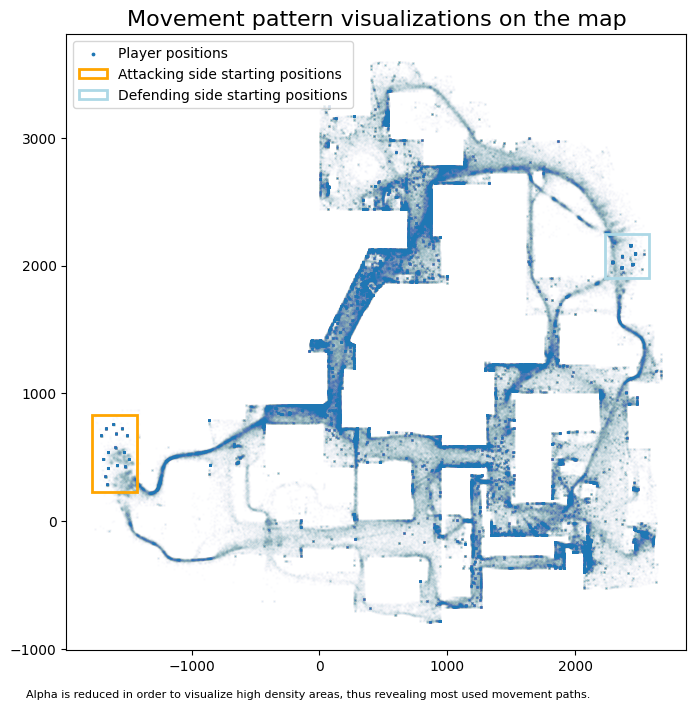

In [71]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(0, 850, s=3, label="Player positions")
ax.scatter(df['x'], df['y'], s=0.5, alpha=0.01, c='#1f77b4')
square_t = patches.Rectangle((-1780, 230), 350, 600, edgecolor='orange', facecolor='none', linewidth=2, label="Attacking side starting positions")
ax.add_patch(square_t)
square_ct = patches.Rectangle((2230, 1900), 350, 350, edgecolor='lightblue', facecolor='none', linewidth=2, label="Defending side starting positions")
ax.add_patch(square_ct)
plt.axis('equal')
plt.legend()
ax.set_title('Movement pattern visualizations on the map', fontsize=16)
plt.figtext(0.075, 0.05, 'Alpha is reduced in order to visualize high density areas, thus revealing most used movement paths.', fontsize=8);

Same concept visualized using heatmaps.

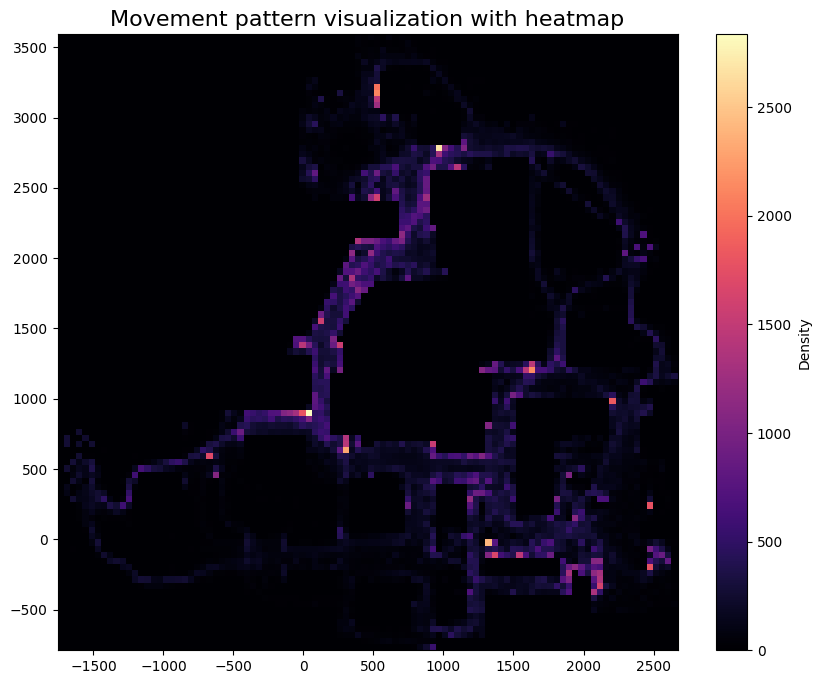

In [73]:
figure = plt.figure(figsize=(10,8))
hb = plt.hist2d(df['x'], df['y'], bins=100,  cmap='magma')
plt.colorbar(hb[3], label='Density')
plt.title('Movement pattern visualization with heatmap', fontsize=16);

Graph level features' correlation matrix

In [236]:
df.loc[df['sec'] == 0]

,x,y,z,roundNum,sec,team1AliveNum,team2AliveNum,CTwinsRound,match_id
0,2469.392334,2092.477539,132.03125,1.0,0.0,5.0,5.0,1,33650798
1,2432.753662,2155.268311,128.03125,1.0,0.0,5.0,5.0,1,33650798
2,2362.105957,1987.731079,128.03125,1.0,0.0,5.0,5.0,1,33650798
3,2368.567383,2071.471436,128.03125,1.0,0.0,5.0,5.0,1,33650798
4,2290.974609,2025.041504,128.03125,1.0,0.0,5.0,5.0,1,33650798
...,...,...,...,...,...,...,...,...,...
5,2445.887695,2014.747925,128.03125,23.0,0.0,5.0,5.0,0,97412521
6,2431.666992,2162.388672,128.03125,23.0,0.0,5.0,5.0,0,97412521
7,2362.448486,1980.053101,128.03125,23.0,0.0,5.0,5.0,0,97412521
8,2291.447021,2033.153809,128.03125,23.0,0.0,5.0,5.0,0,97412521


In [235]:
df.head(20)

,x,y,z,roundNum,sec,team1AliveNum,team2AliveNum,CTwinsRound,match_id
0,2469.392334,2092.477539,132.031250,1.0,0.0,5.0,5.0,1,33650798
1,2432.753662,2155.268311,128.031250,1.0,0.0,5.0,5.0,1,33650798
2,2362.105957,1987.731079,128.031250,1.0,0.0,5.0,5.0,1,33650798
3,2368.567383,2071.471436,128.031250,1.0,0.0,5.0,5.0,1,33650798
4,2290.974609,2025.041504,128.031250,1.0,0.0,5.0,5.0,1,33650798
5,-1595.025024,576.972351,-63.968750,1.0,0.0,5.0,5.0,1,33650798
6,-1672.302979,725.797363,-47.968750,1.0,0.0,5.0,5.0,1,33650798
7,-1706.656982,672.120178,-48.981709,1.0,0.0,5.0,5.0,1,33650798
8,-1490.325806,487.790192,-63.968750,1.0,0.0,5.0,5.0,1,33650798
9,-1656.330078,417.449188,-63.316620,1.0,0.0,5.0,5.0,1,33650798


<Axes: >

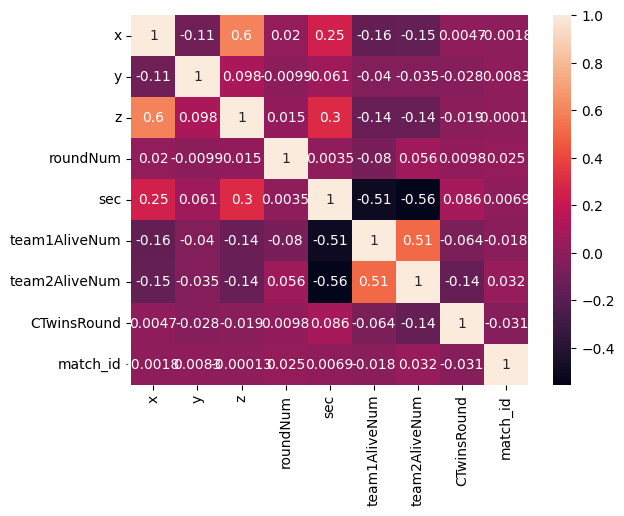

In [240]:
sns.heatmap(df.corr(), annot=True)